In [4]:
import pandas as pd
import numpy as np
import datetime
import requests
from requests.auth import HTTPBasicAuth
import tarfile
import os
import shutil
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math

#keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def get_organize_files(): 
    #download files with images
    #https://talhassner.github.io/home/projects/Adience/Adience-data.html
    BASE_URL = "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification"
    DOWNLOAD_FILES = {
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz": "aligned.tar.gz",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt": "fold_0_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_1_data.txt": "fold_1_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_2_data.txt": "fold_2_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_3_data.txt": "fold_3_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_4_data.txt": "fold_4_data.txt"
                    }

    for DOWNLOAD_FILE, FILE_NAME in DOWNLOAD_FILES.items():
        if not os.path.exists(FILE_NAME):
            print('starting download')
            with open(FILE_NAME, 'wb') as file:
                r = requests.get(DOWNLOAD_FILE, auth = HTTPBasicAuth('adiencedb', 'adience'))
                file.write(r.content)
                print('downloaded {}'.format(FILE_NAME))
    
    
    
    if not os.path.exists('aligned'):
        with tarfile.open('aligned.tar.gz') as file:
            print('unziping images...')
            file.extractall()
            print('images unziped')
        
   
    
    #compile all files catalog
    fold = pd.read_csv('fold_0_data.txt',sep='\t')
    fold.rename(columns={' user_id':'user_id'},inplace=True)
    fold['fold'] = 0
    for i in range(1,5):
        temp = pd.read_csv('fold_'+str(i)+'_data.txt',sep='\t')
        temp['fold'] = i
        fold = fold.append(temp,ignore_index=True)

    fold.dropna(subset=['gender'],inplace=True)
    fold = fold[['user_id','original_image','face_id','age','gender','fold']]
    
    fold = fold.loc[fold.age !='None']
    fold.age.replace(['35'     ,'13'    ,'22'     ,'34'     ,'45'      ,'(27, 32)','23'      ,'55'      ,'36'     ,'(38, 42)','57'      ,'58'      ,'46'      ,'3'      ,'29'     ,'2'     ,'42'],
                     ['(35,43)','(8,13)','(15,24)','(25,34)','(45,100)','(25,34)' ,'(15,24)','(45,100)','(35,43)','(35,43)' ,'(45,100)','(45,100)','(45,100)','(3, 6)','(25,34)','(0, 2)','(35,43)'],
                     inplace = True)
    fold.age.replace(['(38, 43)','(8, 12)','(15, 20)','(60, 100)','(38, 43)','(48, 53)','(4, 6)','(38, 48)','(25, 32)','(8, 23)'],
                     ['(35,43)' ,'(8,13)' ,'(15,24)' ,'(45,100)' ,'(35,43)' ,'(45,100)','(3, 6)','(45,100)','(25,34)' ,'(8,13)'],
                     inplace=True)
     
    train = fold.groupby('gender',as_index=False,group_keys=False).apply(lambda x: x.sample(frac=.5))
    test = fold.drop(train.index.values)
    
    print('Train and test split done')
    
    #creates directories for training, test and validation files
    cwd = os.getcwd()
    
    train_faces = os.path.join(cwd,'train')
    if not os.path.exists(train_faces):
        os.mkdir(train_faces)

    test_faces = os.path.join(cwd,'test')
    if not os.path.exists(test_faces):
        os.mkdir(test_faces)

    #copy images to each directory
    for index, row in train.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(train_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('train images copied')

    for index, row in test.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(test_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('test images copied')
    
    return cwd,train_faces,test_faces,train,test


In [6]:
cwd,train_faces,test_faces,train_images_ids, test_images_ids = get_organize_files()

Train and test split done
train images copied
test images copied


In [7]:
def viz_overfit(model,history,num_of_test_samples,batch_size,target_names,epc):
    
    Y_pred = model.predict(test_generator, math.ceil(num_of_test_samples / batch_size))
    
    print(classification_report(test_generator.classes[:Y_pred.shape[0]],
                                list(np.argmax(Y_pred,axis=1)), 
                                target_names=target_names))


    acc_train = history.history['acc']
    acc_val = history.history['val_acc']
    epochs = range(1,epc+1)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,epc+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [8]:
def Model_age():
    model = Sequential()
    model.add(Conv2D(32, (1, 1), input_shape = (150, 150, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(128, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(256, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    
    model.add(Dense(units = 64, activation = 'relu'))
        
    model.add(Dense(units = 32, activation = 'relu'))
    
    model.add(Dense(units = 7, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=0.001), metrics=['acc'])
    
    return model

model_age = Model_age()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooli

2022-04-18 23:35:17.713988: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 23:35:17.714075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
                    train_images_ids,
                    x_col='original_image',
                    y_col='age',
                    directory=train_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical'
                )

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                    test_images_ids,
                    x_col='original_image',
                    y_col='age',
                    directory=test_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical',
                    shuffle=False
                )

Found 9276 validated image filenames belonging to 7 classes.
Found 9275 validated image filenames belonging to 7 classes.


In [10]:
tf.device('/cpu:0')

checkpoints = 'Model/{epoch:02d}-{val_acc:.2f}.hdf5'

callback_list = [
    keras.callbacks.EarlyStopping(monitor='acc',patience=7),
    keras.callbacks.ModelCheckpoint(filepath=checkpoints, monitor='acc'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,cooldown=2)
]



history_age = model_age.fit(train_generator,
                              steps_per_epoch=93,
                              epochs=2,
                              callbacks=callback_list,
                              validation_data = test_generator,
                              validation_steps=93)
#model_age.save('face_age_detection_augmentation.h5')

Epoch 1/2


2022-04-18 23:35:18.798292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-18 23:35:19.087855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.8929 - acc: 0.2768

2022-04-18 23:37:49.931601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 257s 3s/step - loss: 1.8929 - acc: 0.2768 - val_loss: 1.8758 - val_acc: 0.2767 - lr: 0.0010
Epoch 2/2
93/93 [==============================] - 118s 1s/step - loss: 1.8727 - acc: 0.2782 - val_loss: 1.8529 - val_acc: 0.2767 - lr: 0.0010


2022-04-18 23:41:34.144843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      (0, 2)       0.00      0.00      0.00      1246
     (15,24)       0.00      0.00      0.00       954
     (25,34)       0.28      1.00      0.43      2566
      (3, 6)       0.00      0.00      0.00      1103
     (35,43)       0.00      0.00      0.00      1330
    (45,100)       0.00      0.00      0.00       965
      (8,13)       0.00      0.00      0.00      1111

    accuracy                           0.28      9275
   macro avg       0.04      0.14      0.06      9275
weighted avg       0.08      0.28      0.12      9275



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

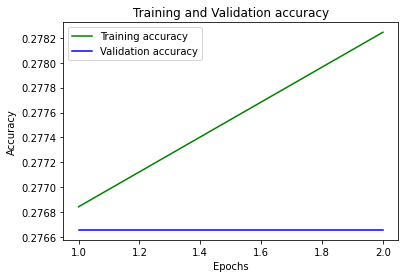

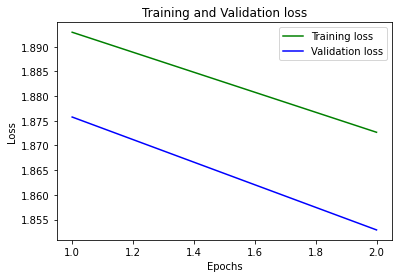

In [11]:
viz_overfit(model_age,
            history_age, 
            train_generator.n,
            train_generator.batch_size,
            list(train_generator.class_indices.keys()),
            len(history_age.epoch))

In [24]:
plt.savefig()

'2022_04_19_00h_05m'